In [2]:
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
from utils import *
from collections import Counter
from scipy.fft import fft, fftfreq, fftshift
import pickle


In [10]:
def build_dataset(df, freq):
    T = df["dt"].mean()
    N = int(np.ceil(1/freq/T*4))
    
    data = {}
    data["freqs"] = []
    for n in range(df.shape[0]//N):
        data["freqs"].extend(fftshift(fftfreq(N, T)))
    for col in ["x", "y", "fy", "fx"]:
        data[col + "f"] = []
        for n in range(df.shape[0]//N):
            data[col + "f"].extend(fftshift(fft(df[col].iloc[N*n:N*(n+1)].values)))
            
    return pd.DataFrame(data)

def prepare_frequency_domain_data(filename):
    freq = int(filename.split("Hz")[0].split("_")[-1])
    df = load_amb_sin_data(filename)
    def to_seconds(x):
        try:
            return x.delta*1e-9
        except:
            return np.nan
    
    df["dt"] = (df["datetime"] - df["datetime"].shift()).apply(to_seconds)
    df["t"]  = df["dt"].cumsum()

    T = df["dt"].mean()

    N = int(np.ceil(1/21/T*4))


    df["x"] = (df["ax"] + df["bx"])/2
    #df["x"] = df["ax"]
    df["y"] = (df["ay"] + df["by"])/2
    #df["y"] = df["ay"]
    df['fx'] = df["f_ax"] + df["f_bx"]
    #df["fx"] = df["f_ax"]
    df['fy'] = df["f_ay"] + df["f_by"]
    #df["fx"] = df["f_ay"]
    df['ex'] = df["e_ax"] + df["e_bx"]
    #df["fx"] = df["f_ax"]
    df['ey'] = df["e_ay"] + df["f_by"]
    
    df = df[["datetime", "x", "y", "fx", "fy", "dt", "t"]]
    
    print(freq)
    
    data = build_dataset(df, freq=freq)
    data = data[np.abs(data["freqs"]) < freq*4]
    return data


def get_response(freq):
    df_x = prepare_frequency_domain_data(filename=f"../amb_sin/sine_fx_{freq}Hz_0RPM.txt")
    df_x["axis"] = "x"
    df_y = prepare_frequency_domain_data(filename=f"../amb_sin/sine_fy_{freq}Hz_0RPM.txt")
    df_y["axis"] = "y"
    df = pd.concat([df_x, df_y], ignore_index=False)
    
    sel_df = df[(df["freqs"] > freq-2) & (df["freqs"] < freq+1)].sort_index()

    inds = list(map(lambda x: x[0], (filter(lambda x: x[1] == 2, Counter(sel_df.index).most_common()))))
    sel_df = sel_df.loc[inds]

    Us = []
    Ys = []
    for name, group in sel_df.groupby(sel_df.index):
        U = group[["xf", "yf"]].values.transpose()
        Y = group[["fxf", "fyf"]].values.transpose()
        Us.append(U)
        Ys.append(Y)
    Us = np.array(Us)
    Ys = np.array(Ys)
    
    G = np.mean(Ys, axis=0) @ np.linalg.inv(np.mean(Us,axis=0))
    C = np.imag(G) / (2*np.pi*freq)
    K = np.real(G) + (2*np.pi*freq)**2*np.array([[1, 0],[0, 1]])
    
    return {"freq": freq,
            "G"   : G,
            "C"   : C,
            "K"   : K}

#get_response(5)    

def get_files_frequencies(dirs="../amb_sin/"):
    files = os.listdir(dirs)
    files = filter(lambda x: x.endswith(".txt"), files)
    files = map(lambda x: int(x.split("Hz")[0].split("_")[-1]), files)
    files = np.unique(list(files))
    return files


responses = []
for freq in get_files_frequencies():
    responses.append(get_response(freq))

5
5
9
9
13
13
17
17
21
21
25
25
29
29
33
33
37
37
41
41
45
45
49
49
53
53
57
57
61
61
65
65
69
69


In [6]:
with open('results/frequency_eiv_results.pickle', 'wb') as handle:
    pickle.dump(responses, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
Cs = np.array([d["C"] for d in responses])
Ks = np.array([d["K"] for d in responses])
Fs = np.array([d["freq"] for d in responses])

In [8]:
Ks.shape

(17, 2, 2)

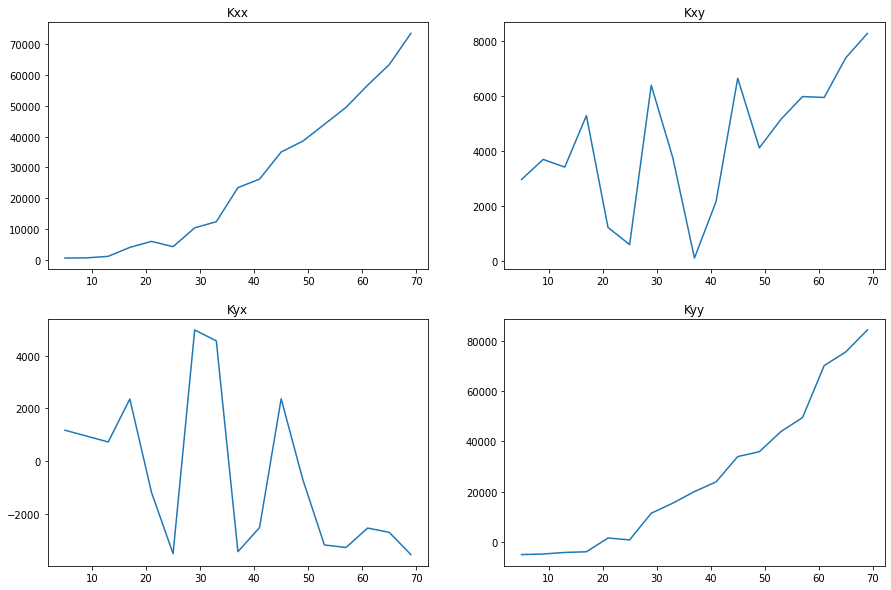

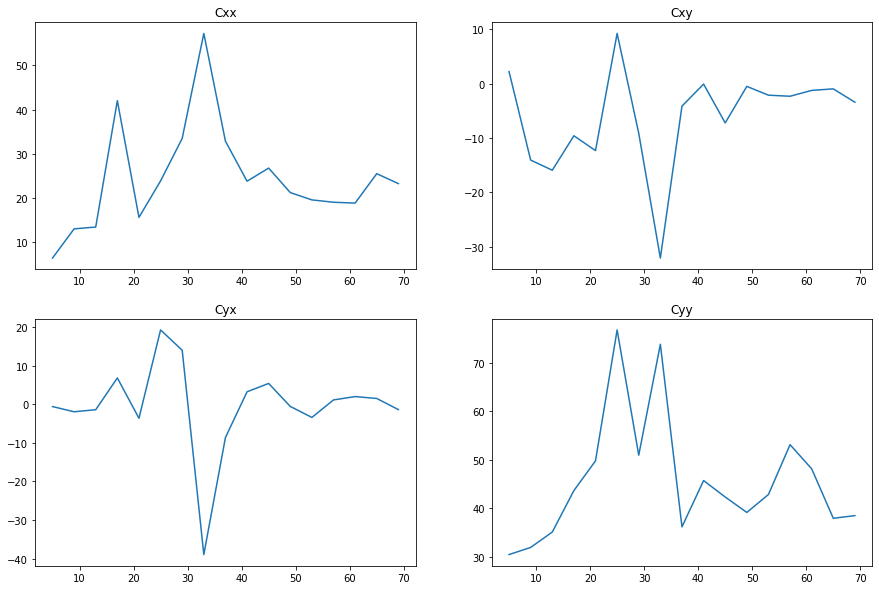

In [9]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
axs[0,0].plot(Fs, Ks[:, 0, 0])
axs[0,0].set_title("Kxx")

axs[0,1].plot(Fs, Ks[:, 0, 1])
axs[0,1].set_title("Kxy")

axs[1,0].plot(Fs, Ks[:, 1, 0])
axs[1,0].set_title("Kyx")

axs[1,1].plot(Fs, Ks[:, 1,1])
axs[1,1].set_title("Kyy")


fig, axs = plt.subplots(2,2, figsize=(15,10))
axs[0,0].plot(Fs, Cs[:, 0, 0])
axs[0,0].set_title("Cxx")

axs[0,1].plot(Fs, Cs[:, 0, 1])
axs[0,1].set_title("Cxy")

axs[1,0].plot(Fs, Cs[:, 1, 0])
axs[1,0].set_title("Cyx")

axs[1,1].plot(Fs, Cs[:, 1,1])
axs[1,1].set_title("Cyy")

fig.show()


In [11]:
# Outro estimador

In [12]:
def build_dataset(df, freq):
    T = df["dt"].mean()
    N = int(np.ceil(1/freq/T*4))
    
    data = {}
    data["freqs"] = []
    for n in range(df.shape[0]//N):
        data["freqs"].extend(fftshift(fftfreq(N, T)))
    for col in ["x", "y", "fy", "fx", "ey", "ex"]:
        data[col + "f"] = []
        for n in range(df.shape[0]//N):
            data[col + "f"].extend(fftshift(fft(df[col].iloc[N*n:N*(n+1)].values)))
            
    return pd.DataFrame(data)

def prepare_frequency_domain_data(filename):
    freq = int(filename.split("Hz")[0].split("_")[-1])
    df = load_amb_sin_data(filename)
    def to_seconds(x):
        try:
            return x.delta*1e-9
        except:
            return np.nan
    
    df["dt"] = (df["datetime"] - df["datetime"].shift()).apply(to_seconds)
    df["t"]  = df["dt"].cumsum()

    T = df["dt"].mean()

    N = int(np.ceil(1/21/T*4))


    df["x"] = (df["ax"] + df["bx"])/2
    #df["x"] = df["ax"]
    df["y"] = (df["ay"] + df["by"])/2
    #df["y"] = df["ay"]
    df['fx'] = df["f_ax"] + df["f_bx"]
    #df["fx"] = df["f_ax"]
    df['fy'] = df["f_ay"] + df["f_by"]
    #df["fx"] = df["f_ay"]
    df['ex'] = df["e_ax"] + df["e_bx"]
    #df["fx"] = df["f_ax"]
    df['ey'] = df["e_ay"] + df["f_by"]
    
    df = df[["datetime", "x", "y", "fx", "fy", "ex", "ey", "dt", "t"]]
    
    print(freq)
    
    data = build_dataset(df, freq=freq)
    data = data[np.abs(data["freqs"]) < freq*4]
    return data


def get_response(freq):
    df_x = prepare_frequency_domain_data(filename=f"../amb_sin/sine_fx_{freq}Hz_0RPM.txt")
    df_x["axis"] = "x"
    df_y = prepare_frequency_domain_data(filename=f"../amb_sin/sine_fy_{freq}Hz_0RPM.txt")
    df_y["axis"] = "y"
    df = pd.concat([df_x, df_y], ignore_index=False)
    
    sel_df = df[(df["freqs"] > freq-2) & (df["freqs"] < freq+1)].sort_index()

    inds = list(map(lambda x: x[0], (filter(lambda x: x[1] == 2, Counter(sel_df.index).most_common()))))
    sel_df = sel_df.loc[inds]

    Us = []
    Ys = []
    Ss = []
    for name, group in sel_df.groupby(sel_df.index):
        U = group[["xf", "yf"]].values.transpose()
        Y = group[["fxf", "fyf"]].values.transpose()
        S = group[["exf", "eyf"]].values.transpose()
        Us.append(U)
        Ys.append(Y)
        Ss.append(S)
        
    Us = np.array(Us)
    Ys = np.array(Ys)
    Ss = np.array(Ss)
    
    G = np.mean(Ys*Ss, axis=0) @ np.linalg.inv(np.mean(Us*Ss,axis=0))
    C = np.imag(G) / (2*np.pi*freq)
    K = np.real(G) + (2*np.pi*freq)**2*np.array([[1, 0],[0, 1]])
    
    return {"freq": freq,
            "G"   : G,
            "C"   : C,
            "K"   : K}

#get_response(5)    

def get_files_frequencies(dirs="../amb_sin/"):
    files = os.listdir(dirs)
    files = filter(lambda x: x.endswith(".txt"), files)
    files = map(lambda x: int(x.split("Hz")[0].split("_")[-1]), files)
    files = np.unique(list(files))
    return files


responses = []
for freq in get_files_frequencies():
    responses.append(get_response(freq))

5
5
9
9
13
13
17
17
21
21
25
25
29
29
33
33
37
37
41
41
45
45
49
49
53
53
57
57
61
61
65
65
69
69


In [14]:
Cs = np.array([d["C"] for d in responses])
Ks = np.array([d["K"] for d in responses])
Fs = np.array([d["freq"] for d in responses])

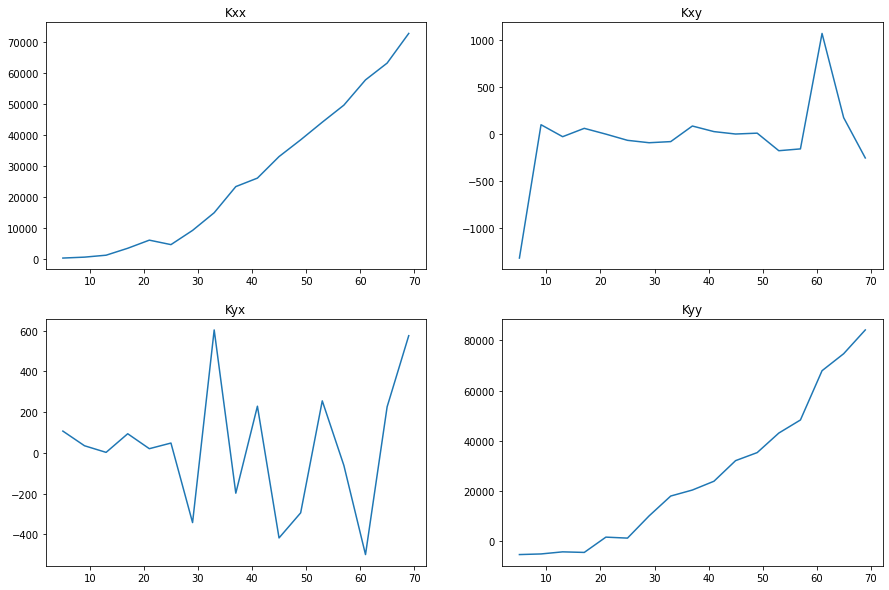

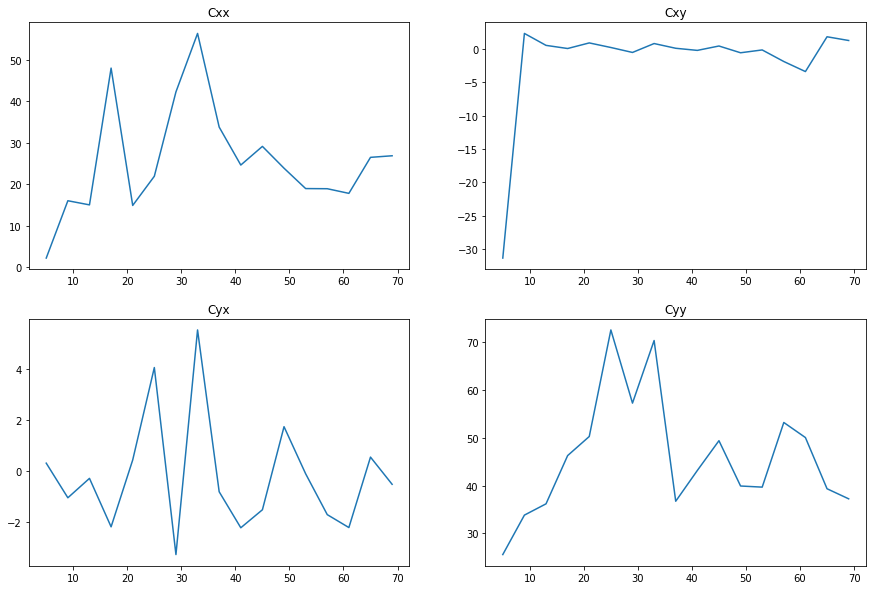

In [15]:
fig, axs = plt.subplots(2,2, figsize=(15,10))
axs[0,0].plot(Fs, Ks[:, 0, 0])
axs[0,0].set_title("Kxx")

axs[0,1].plot(Fs, Ks[:, 0, 1])
axs[0,1].set_title("Kxy")

axs[1,0].plot(Fs, Ks[:, 1, 0])
axs[1,0].set_title("Kyx")

axs[1,1].plot(Fs, Ks[:, 1,1])
axs[1,1].set_title("Kyy")


fig, axs = plt.subplots(2,2, figsize=(15,10))
axs[0,0].plot(Fs, Cs[:, 0, 0])
axs[0,0].set_title("Cxx")

axs[0,1].plot(Fs, Cs[:, 0, 1])
axs[0,1].set_title("Cxy")

axs[1,0].plot(Fs, Cs[:, 1, 0])
axs[1,0].set_title("Cyx")

axs[1,1].plot(Fs, Cs[:, 1,1])
axs[1,1].set_title("Cyy")

fig.show()

In [16]:
with open('results/frequency_jio_results.pickle', 'wb') as handle:
    pickle.dump(responses, handle, protocol=pickle.HIGHEST_PROTOCOL)